In [5]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

import torchvision
import torchaudio
torch.__version__
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

print(device)

OSError: dlopen(/Users/mayuan/WorkSpace/SoftWare/miniconda3/envs/deeplearn/lib/python3.9/site-packages/torchaudio/lib/libtorchaudio.so, 0x0006): Symbol not found: __ZN2at4_ops6conv1d4callERKNS_6TensorES4_RKN3c108optionalIS2_EENS5_8ArrayRefIxEESB_SB_x
  Referenced from: <8E036663-1C4D-353B-A6A3-932835C35048> /Users/mayuan/WorkSpace/SoftWare/miniconda3/envs/deeplearn/lib/python3.9/site-packages/torchaudio/lib/libtorchaudio.so
  Expected in:     <EEA9DBAE-D739-32BF-BF5C-B495A4B0502E> /Users/mayuan/WorkSpace/SoftWare/miniconda3/envs/deeplearn/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib

In [ ]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.tanh(self.fc2(x)) * self.action_bound


class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1) # 拼接状态和动作
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

In [ ]:
class DDPG:
    ''' DDPG算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        # 初始化目标价值网络并设置和价值网络相同的参数
        self.target_critic.load_state_dict(self.critic.state_dict())
        # 初始化目标策略网络并设置和策略相同的参数
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差,均值直接设为0
        self.tau = tau  # 目标网络软更新参数
        self.action_dim = action_dim
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state).item()
        # 给动作添加噪声，增加探索
        action = action + self.sigma * np.random.randn(self.action_dim)
        return action

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        next_q_values = self.target_critic(next_states, self.target_actor(next_states))
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)
        critic_loss = torch.mean(F.mse_loss(self.critic(states, actions), q_targets))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.actor, self.target_actor)  # 软更新策略网络
        self.soft_update(self.critic, self.target_critic)  # 软更新价值网络

In [ ]:
actor_lr = 3e-4
critic_lr = 3e-3
num_episodes = 200
hidden_dim = 64
gamma = 0.98
tau = 0.005  # 软更新参数
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.01  # 高斯噪声标准差
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v0'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device)

return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

/Users/mayuan/WorkSpace/SoftWare/miniconda3/envs/deeplearn/lib/python3.9/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
Iteration 0:   0%|          | 0/20 [00:00<?, ?it/s]/var/folders/xy/jcggb9nj30b6vxhtb3fzqqc40000gn/T/ipykernel_26722/1543697300.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 20/20 [00:04<00:00,  4.59it/s, episode=200, return=-271.209]


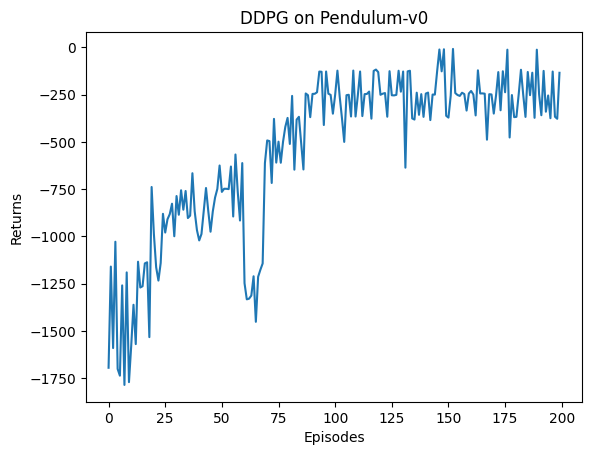

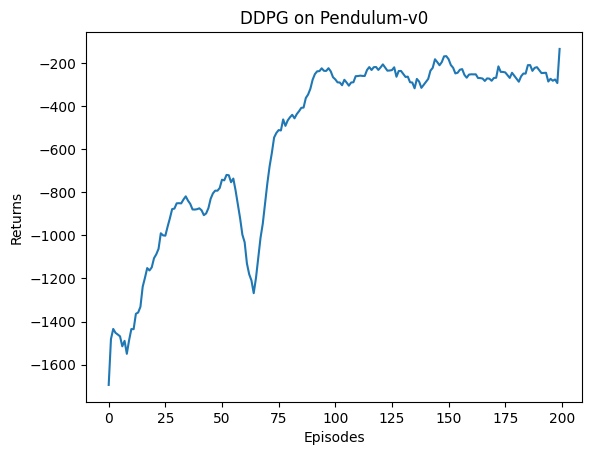

In [ ]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()